# Evaluierung von Parsingtechniken

Das Verarbeitung von textbasierten Dateien ist ein wichtiger Mechanismus, welcher einen wichtigen Bestandteil bei der Implementierung von Softwaresystemen darstellt. Die produktiven Einsatzgebiete dieser Verarbeitung sind vielfältig, ein kleiner Auszug möglicher dieser Einsatzgebiete wäre dabei:

- die Verarbeitung von eingegebenen Daten in Textform
- die Verarbeitung von Quelltexten durch einen Kompiler
- die syntaktische bzw. semantische Analyse von Blocktexten
- das Evaluieren von Projektabhängigkeiten durch einen Paketmanager
- das Rendern von HTML Templates
- das Serialisieren bzw. Deserialisieren von Text aus bzw. in komplexen Datenstrukturen zur Übertragung
- die Extraktion von Werten aus Konfigurationsdateien
- ...


## Motivation und Ziel

Libg3n ist eine Bibliothek, welche mit Hilfe von Methoden der Generativen Programmierung eine neue Art der Bereitstellung von Programmbibliotheken schaffen soll. Dabei sollen an bestimmten Variationspunkten innerhalb dieser Programmbibliotheken eine Spezialisierung auf das Projekt stattfinden, welches die Programmbibliothek nutzen soll. Um dies zu erreichen, soll eine *Domain-Specific-Language* (DSL) definiert werden, welche einem Codegenerator als Eingabegröße dient und die expliziten Werte für die einzelnen Variationspunkte liefert. Dementsprechend wurde im Vorfeld eine Grammatik und ein zugehöriges Dateiformat definiert. Als Dateiendung wurde dafür `.gen` gewählt, um zu zeigen, dass der enthaltene Text in Form der DSL vorliegt. Diese Konfigurationsdateien müssen somit für eine Weiterverarbeitung zunächst verarbeitet werden, was wiedrum die Implementation eines Parsers erfordert.

In dieser Arbeit sollen verschiedene Parsingtechniken evaluiert werden, um die Inhalte von Konfigurationsdateien der Libg3n Bibliothek zu verarbeiten. Dazu wurden im Vorfeld die folgenden Techniken ausgewählt:

- die Konzeption und Implementierung eines Parsers mit python
- die Implementierung einer Parsingmethode unter Verwendung der *pyparsing* Biliothek
- die Definition der Variationspunkte in einer YAML Datei und ein Parsing mit der *PyYaml* Bibliothek
- die Definition der Variationspunkte in einer XML Datei und Verwendung der nativen XML Bibliothek von Python

Dabei sollen die Ergebnisse nach unterschiedlichen Gesichtspunkten betrachtet werden. Zunächst soll im Rahmen dieser Evaluierung festgestellt werden, welche Techniken sich für eine möglichst schnelle Verarbeitung der Konfigurationsdateien eignen. Die Verarbeitungsgeschwindigkeit soll dabei in Relation zu der Größe der Eingabedatei bzw. der Anzahl in ihr festgehaltener Datenpunkte gesetzt werden. Darüber hinaus sollen die verschiedenen verwendeten Dateitypen bezüglich deren Eignung zur (leserlichen) Darstellung von Strukturen der Libg3n Bibliothek verglichen werden. Als dritter Gesichtspunkt soll die Stabilität der jeweiligen Methodik betrachtet werden. Dazu sollen die Messergebnisse verschiedener Testdurchläufe verglichen werden, um eventuelle Instabilitäten in der Ausführungszeit aufzudecken.


## Definition Parsing

Um nachfolgend Parsingtechniken evaluieren zu können, muss zunächst der Begriff des Parsings betrachtet und definiert werden. Dabei wird nach *Gabriele Tomassetti* [1] der Vorgang des Parsing beschrieben als:
> The analysis of an input to organize the data according to the rule of a grammar

Demnach kann festgehalten werden, dass die Syntax des zu verarbeitenden Textes a priori keine Rolle spielt, solange der verarbeitende Parser eine Grammatik besitzt, welche die Daten in eine andere Form überführen kann. Das Ziel ist es dabei stets, Informationen aus dem eingegebenen Text zu extrahieren. Durch die Unabhängigkeit von der Form der Daten ergibt sich dabei allerdings der große Vorteil, dass jede, der Textform übergeordnete Darstellungsform, abgebildet werden kann.


## Abhängigkeiten

Um die verschiedenen Mesungen durchführen und auswerten zu können, werden verschiedene Bibliotheken genutzt, welche sich auf diese Fachgebiete spezialisiert und innerhalb von Wissenschaftskreisen etabliert haben. Dazu zählen:

- _matplotlib_: Eine Bibliothek zur grafischen und statistischen Auswertung von Zahlenwerten [2]
- _pandas_: Eine umfängliche und effiziente Bibliothek zur generellen Datenanalyse [3]
- _numpy_: Eine Bibliothek für wissenschaftliche Berechnungen [4]

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Konfiguration

Über die Konfigurationsvariable `RUNS` kann festgelegt werden, wie viele Messdurchläufe pro Datenset durchgeführt werden sollen. So können die Ergebnisse, vor allem in Hinblick auf die Langzeitstabilität, besser betrachtet werden.

In [2]:
RUNS = 20

## PerformanceTimer

In der Klasse `PerformanceTimer` sind alle Funktionen gekapselt, die zu einer Zeitmessung bei der Ausführung einer Funktion erforderlich sind.

Bei der Initialisierung kann dem entsprechenden Timer ein eindeutiger Name zugewiesen werden, um diesen später eindeutig identifizieren zu können. Desweiteren kann über einen zusätzlichen Parameter die Messdurchläufe je Set bestimmt werden.

Die Klasse definiert darüber hinaus die Funktion `measure_function`, welcher die Referenz auf eine Funktion und deren Argumente als Parameter übergeben werden. In diesem Fall spiegeln die Argumente dabei zudem die verschiedenen Eingabesets wieder, da es sich dabei um eine Liste von Pfaden zu Konfigurationsdateien handelt. Die Testkonfigurationen sind dabei im Unterordner `/samples` zu finden. Die Konfigurationen unterscheiden sich ausschließlich in der Anzahl von enthaltenen Datenpunkten. Die Funktion führt daraufhin für jede Konfigurationsdatei die definierte Anzahl von Messiterationen durch, wobei jeweils mit den Klassenfunktionen `start_function` und `stop_function` die Messung gestartet bzw. gestoppt wird. Der Messvorgang wird dabei durch die python-native *time* Bibliothek bzw. der von ihr bereitgestellten Funktion `perf_counter()` realisiert. Nach einem Set an Messungen mit einer Konfigurationsdatei kann mittels der Funktion `reset` der Messtatus zurückgesetzt werden.

Darüber hinaus definiert die Klasse noch zwei weitere Funktionen, welche der Vereinfachung der anschließenden Auswertung dienen. Zum einen wurde die Funktion `average_time` implementiert, welche die mittleren Messwerte aller Sets von Messungen zurückgibt. Desweiteren können mit Hilfe der Funktion `print` alle gesammelten Messinformationen in Textform dargestellt werden.

In [3]:
import time

class PerformanceTimer:
    timers = {}

    def __init__(self, name: str = "", iterations: int = 20):
        self.running = False
        self.start = None
        self.name = name
        self.elapsed = 0.0
        self.measurements = {}
        self.successful_measurements = 0
        self.iterations = iterations

        PerformanceTimer.timers[self.name] = self

    def measure_function(self, func, *args):
        for i, arg in enumerate(args):
            self.measurements[i] = []
            for j in range(self.iterations):
                self.start_timer()
                func(arg)
                self.stop_timer()
                self.measurements[i].append(self.elapsed)
                self.successful_measurements += 1
                self.reset()

    def start_timer(self):
        if self.running is False:
            self.start = time.perf_counter()
            self.running = True
        else:
            raise Exception('Timer already started.')

    def stop_timer(self):
        if self.running is True:
            # Elapsed time in ms
            self.elapsed = (time.perf_counter() - self.start) * 1000
            self.running = False
        else:
            raise Exception('Timer is not running.')

    def reset(self):
        self.start = None
        self.elapsed = 0.0
        self.running = False

    def average_time(self):
        result = []

        # Iterate over all measurement sets
        for measurement_set in self.measurements.values():

            # Create dataframe from values
            df = pd.DataFrame(measurement_set)

            # Calculate 99th quantile
            q = df.quantile(0.99)

            # Filter dataframe by 99th quantile
            df = df[df < q]

            # Calculate mean value and append to results
            result.append(df.mean().values[0])

        # Return the results
        return result

    def print(self):
        print(('Timer: ' + self.name).center(50, '-'))
        print('Finished: ' + str(not self.running))
        print('Sample Sets: ' + str(len(self.measurements)))
        print('Measurements: ' + str(self.successful_measurements))

        if self.measurements:
            print('Measured Times: ' + str(self.measurements))
        else:
            print('Elapsed Time: ' + str(self.elapsed))

        print('\n')

## Manuelles Parsing

Das manuelle Parsing basiert auf einer, für die Biliothek Libg3n eigens definierten DSL. Dementsprechend wurde ein Parser konzipiert, welcher sich auf die Textverarbeitungsfähigkeiten nativer python Bibliotheken stützt. Der vollständige Quellcode des Parsers kann in dem Unterordner `/parse_manual` betrachtet werden.

Der Parser definiert zunächst mehrere konstante Listen, welche Teilstücke der DSL Grammatik abbilden. So werden beispielsweise zulässige Schlüsselwörter, Symbole und Stoppwörter deklariert. Bevor mit diesen Listen gearbeitet werden kann, muss zunächst die übergebene Konfigurationsdatei geöffnet und der Inhalt extrahiert werden. Dies wird von Hilfsfunktionen innerhalb der Parserklasse übernommen. Darüber hinaus muss der ausgelesene Inhalt der Dateien durch einen *Lexer* [<sup>1</sup>](#fn1) in eine Liste von einzelnen *Token* übersetzt werden. Folgend kann die Liste der Token auf feste Muster untersucht werden, welche durch die Grammatik vorgegeben werden.

In dem Fall des Libg3n Parsers werden die so erkannten Muster in Funktions- und Klassennotationen übersetzt, welche zur Vereinfachung durch triviale Datenklassen repräsentiert werden.

[1](#fn1):<small id="fn1"> Programm bzw. Routine zur lexikalischen Analyse eines Textes, wobei dieser in sinnvolle Token zerlegt wird. [5]</small>

### Manuelles Parsing - Durchführung der Messungen

In [4]:
from parse_manual.parser import parse as parse_manual

manual_timer = PerformanceTimer('Manual Parsing', RUNS)
manual_timer.measure_function(parse_manual, './samples/sample.gen', './samples/sample-40.gen',
                              './samples/sample-80.gen', './samples/sample-160.gen')
manual_timer.print()

--------------Timer: Manual Parsing---------------
Finished: True
Sample Sets: 4
Measurements: 80
Measured Times: {0: [0.5652500000001837, 0.31983299999982506, 0.3054580000001472, 0.3734159999999598, 0.4418330000000026, 0.5862090000001707, 0.6584169999999112, 0.6157920000000594, 0.5756660000000302, 0.5971250000000872, 0.5824579999997859, 0.5193750000000996, 0.465041999999638, 0.5788330000000563, 0.5038339999998698, 0.5024160000002276, 0.4895829999997936, 0.49091700000003513, 0.4894580000001092, 0.48508399999969143], 1: [0.863832999999925, 0.6279590000000113, 0.6029999999999092, 0.6005829999997658, 0.6021660000001816, 0.8989999999999831, 0.972709000000016, 0.8724169999996256, 0.8461250000002529, 0.8471659999997883, 0.8458749999999959, 0.8455409999998942, 0.8457920000002339, 0.8438749999997164, 0.8617499999998834, 0.8697089999998298, 0.7991659999997403, 0.8038749999998984, 0.8015419999995999, 0.7258339999998142], 2: [1.4948749999996735, 1.4333330000000366, 1.4094590000000018, 1.417416999

### Manuelles Parsing - Ausführungszeit im Messverlauf

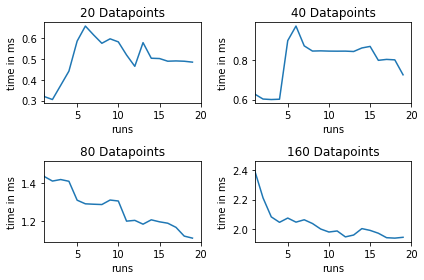

In [5]:
plt.subplot(2, 2, 1)
plt.plot(manual_timer.measurements[0])
plt.title('20 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 2)
plt.plot(manual_timer.measurements[1])
plt.title('40 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 3)
plt.plot(manual_timer.measurements[2])
plt.title('80 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 4)
plt.plot(manual_timer.measurements[3])
plt.title('160 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.rcParams['figure.figsize'] = [30 / 2.54, 15 / 2.54]
plt.tight_layout()
plt.show()

### Manuelles Parsing - Ergebnisse

In [6]:
df = pd.DataFrame(manual_timer.measurements)
df.columns = ['20 Datapoints', '40 Datapoints', '80 Datapoints', '160 Datapoints']
df

,20 Datapoints,40 Datapoints,80 Datapoints,160 Datapoints
0,0.565250,0.863833,1.494875,2.438333
1,0.319833,0.627959,1.433333,2.396042
2,0.305458,0.603000,1.409459,2.212375
3,0.373416,0.600583,1.417417,2.083083
4,0.441833,0.602166,1.408291,2.046083
5,0.586209,0.899000,1.309709,2.075125
6,0.658417,0.972709,1.290833,2.047375
7,0.615792,0.872417,1.288708,2.063375
8,0.575666,0.846125,1.287084,2.037958
9,0.597125,0.847166,1.310542,2.000458


## Pyparsing

Ein weiter Ansatz zur Verarbeitung der Konfigurationsdateien stellt die Verwendung der *pyparsing* Bibliothek dar. Es handelt sich dabei um eine Bibliothek zur Definition und Verarbeitung einfacher Grammatiken. Eine Besonderheit stellt dabei die direkte Definition der Grammatik als python Code dar, welcher einfach zu lesen ist und sich nahtlos in die Definition des Parsers einfügt. Die Grammatik für die Libg3n DSL kann so mit nur wenigen Zeilen python Code definiert werden:

```python
function = Literal('function') + Word(alphanums) + Opt(':' + Word(alphanums)) + Word(alphanums)
property = Literal('property') + Word(alphanums) + Literal(':') + Word(alphanums)
cls = Literal('class') + Word(alphanums) + Opt(':' + Word(alphanums)) + ZeroOrMore(property)
grammar = OneOrMore(function ^ cls)
```

Ist die Grammatik definiert, kann der Inhalt einer Datei durch folgenden Ausdruck verarbeitet werden:

```python
grammar.parseFile(path_to_file)
```

### Pyparsing - Durchführung der Messungen

In [7]:
from parse_pyparsing.parser import parse as parse_pyparsing

# Pyparsing
pyparsing_timer = PerformanceTimer('Pyparsing', RUNS)
pyparsing_timer.measure_function(parse_pyparsing, './samples/sample.gen', './samples/sample-40.gen',
                                 './samples/sample-80.gen', './samples/sample-160.gen')
pyparsing_timer.print()

-----------------Timer: Pyparsing-----------------
Finished: True
Sample Sets: 4
Measurements: 80
Measured Times: {0: [2.9587920000002654, 2.385124999999988, 2.3375830000000875, 2.3303750000001067, 2.33329200000032, 2.4058750000000018, 2.323082999999837, 2.4572499999999664, 2.7045000000001096, 3.702249999999907, 2.853958000000212, 3.4112080000001654, 2.9672080000002765, 2.449707999999884, 3.448624999999872, 4.153290999999726, 2.786334000000057, 2.4037080000001154, 3.2311250000001124, 3.5944580000002446], 1: [4.850333999999901, 4.7239999999999505, 4.721707999999936, 5.574874999999757, 4.959041999999858, 6.295208000000052, 6.441499999999767, 5.175249999999743, 4.768292000000063, 4.7784580000000965, 4.623333000000063, 4.627833000000248, 4.626333000000038, 4.630542000000126, 5.1994999999998015, 5.137916000000242, 4.618917000000167, 4.369500000000137, 4.891042000000123, 5.144625000000236], 2: [9.114332999999863, 9.226125000000085, 8.681999999999856, 8.826, 8.835667000000047, 8.7339169999998

### Pyparsing - Ausführungszeit im Messverlauf

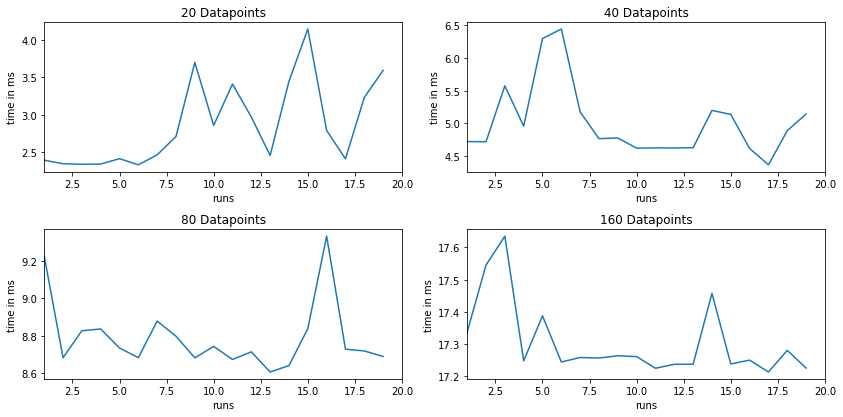

In [8]:
plt.subplot(2, 2, 1)
plt.plot(pyparsing_timer.measurements[0])
plt.title('20 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 2)
plt.plot(pyparsing_timer.measurements[1])
plt.title('40 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 3)
plt.plot(pyparsing_timer.measurements[2])
plt.title('80 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 4)
plt.plot(pyparsing_timer.measurements[3])
plt.title('160 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.rcParams['figure.figsize'] = [30 / 2.54, 15 / 2.54]
plt.tight_layout()
plt.show()

### Pyparsing - Ergebnisse

In [9]:
df = pd.DataFrame(pyparsing_timer.measurements)
df.columns = ['20 Datapoints', '40 Datapoints', '80 Datapoints', '160 Datapoints']
df

,20 Datapoints,40 Datapoints,80 Datapoints,160 Datapoints
0,2.958792,4.850334,9.114333,17.409875
1,2.385125,4.724000,9.226125,17.337416
2,2.337583,4.721708,8.682000,17.545041
3,2.330375,5.574875,8.826000,17.634250
4,2.333292,4.959042,8.835667,17.248375
5,2.405875,6.295208,8.733917,17.387750
6,2.323083,6.441500,8.682291,17.244875
7,2.457250,5.175250,8.877583,17.258625
8,2.704500,4.768292,8.796667,17.257083
9,3.702250,4.778458,8.681250,17.264125


## YAML

YAML ist eine Beschreibungssprache für das Serialisieren von Daten, welche Integrationen für alle bekannten Programmiersprachen aufweist. [7] Vor allem im Bereich der Webentwicklung wird YAML oft als Notation für Konfigurationswerte genutzt. Durch die bereits erwähnten Integrationen, in diesem Fall durch das *PyYAML* Modul für Python, ist die Implementation eines Parsers trivial und wird im wesentlichen durch diesen Ausdruck gekapselt:

```python
yaml.safe_load(path_to_file)
```

Dadurch wird die Datei, welche sich an dem übergebenen Dateipfad befindet, geladen und der Inhalt syntaktisch geprüft. Darüber hinaus wird der Inhalt der Datei verarbeitet und in ein Python Dictionary übersetzt.

### YAML - Durchführung der Messungen

In [10]:
from parse_yaml.parser import parse as parse_yaml

#YAML
yaml_timer = PerformanceTimer('YAML Parsing', RUNS)
yaml_timer.measure_function(parse_yaml, './samples/sample.yaml', './samples/sample-40.yaml', './samples/sample-80.yaml',
                            './samples/sample-160.yaml')
yaml_timer.print()

---------------Timer: YAML Parsing----------------
Finished: True
Sample Sets: 4
Measurements: 80
Measured Times: {0: [9.562750000000175, 8.01475000000007, 7.871249999999996, 11.977458000000052, 8.112083999999964, 10.431625000000277, 8.29000000000013, 8.340374999999955, 10.411500000000018, 8.242833000000171, 31.91491699999993, 7.2722920000001245, 7.17304200000024, 7.253249999999767, 7.471874999999795, 7.7201249999996335, 7.913499999999907, 7.456083000000113, 7.4349159999993475, 7.2420410000004765], 1: [14.753040999999634, 14.142707999999615, 14.329041999999959, 15.138000000000318, 15.455792000000024, 14.6405000000005, 14.243417000000314, 14.627458999999732, 14.165708000000166, 14.147083000000116, 14.59354200000007, 14.539749999999962, 14.43516699999936, 14.26120899999983, 14.29583299999937, 14.489000000000196, 14.44429100000022, 14.504957999999846, 14.345250000000753, 14.294083000000235], 2: [28.775917000000817, 28.186042000000633, 28.13179099999985, 28.195000000000192, 28.188082999999

### YAML - Ausführungszeit im Messverlauf

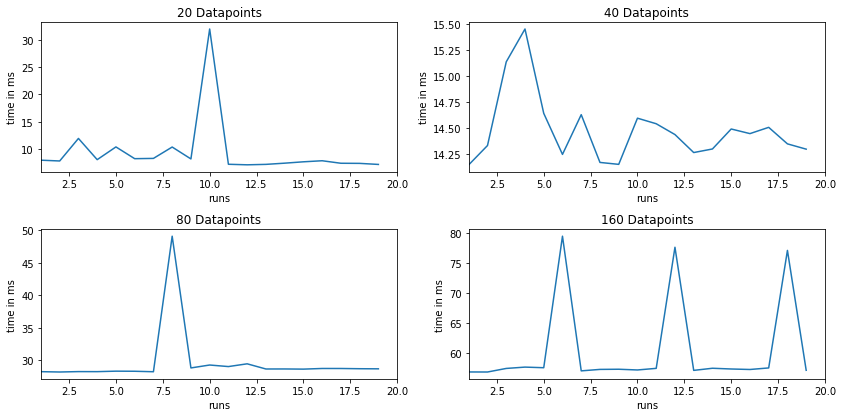

In [11]:
plt.subplot(2, 2, 1)
plt.plot(yaml_timer.measurements[0])
plt.title('20 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 2)
plt.plot(yaml_timer.measurements[1])
plt.title('40 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 3)
plt.plot(yaml_timer.measurements[2])
plt.title('80 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 4)
plt.plot(yaml_timer.measurements[3])
plt.title('160 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.rcParams['figure.figsize'] = [30 / 2.54, 15 / 2.54]
plt.tight_layout()
plt.show()

### YAML - Ergebnisse

In [12]:
df = pd.DataFrame(yaml_timer.measurements)
df.columns = ['20 Datapoints', '40 Datapoints', '80 Datapoints', '160 Datapoints']
df

,20 Datapoints,40 Datapoints,80 Datapoints,160 Datapoints
0,9.562750,14.753041,28.775917,78.735208
1,8.014750,14.142708,28.186042,56.827292
2,7.871250,14.329042,28.131791,56.818208
3,11.977458,15.138000,28.195000,57.412584
4,8.112084,15.455792,28.188083,57.633875
5,10.431625,14.640500,28.263042,57.532458
6,8.290000,14.243417,28.247584,79.423333
7,8.340375,14.627459,28.172917,57.008541
8,10.411500,14.165708,49.111875,57.252125
9,8.242833,14.147083,28.761083,57.279500


## XML

XML steht für *Extensible Markup Language* und dient als Notation zur Strukturierung von Daten in Textform. [8] Der Syntax von HTML ähnelt dabei der anderer Markupsprachen wie z.B. HTML, bietet allerdings den Vorteil, dass die einzelnen Elemente selbst definiert werden können.

Die Implementation eines XML Parsers mit Python ist dabei ohne zusätzliche Bibliotheken möglich. Python bietet dafür bereits eine native Bibliothek an, welche den Syntaxbaum einer XML-Datei extrahieren kann. Dies erfolgt mit Hilfe der Klasse `ElementTree`, welche per Parameter der Pfad zu einer XML-Datei übergeben werden kann:

```python
xml.etree.ElementTree(file=path_to_xml_file)
```

Folgend können Elemente dieses Baumes nach spezifischen Knoten durchsucht werden und über eine Liste der Suchergebnisse iteriert werden:

```python
# Find all functions Nodes
functions = element_tree.findall('func')

# Iterate over all function nodes
for function in functions:
        # Process the function node
        new_function = process_function(function)
        # Save new function inside the functions dict
        function_dict[new_function.name] = new_function
```

### XML - Durchführung der Messungen

In [13]:
from parse_xml.parser import parse as parse_xml

#XML
xml_timer = PerformanceTimer('XML Parsing', RUNS)
xml_timer.measure_function(parse_xml, './samples/sample.xml', './samples/sample-40.xml', './samples/sample-80.xml',
                           './samples/sample-160.xml')
xml_timer.print()

----------------Timer: XML Parsing----------------
Finished: True
Sample Sets: 4
Measurements: 80
Measured Times: {0: [0.2808329999997028, 0.10166699999913931, 0.09350000000019065, 0.0900420000000679, 0.08845799999956938, 0.08699999999972619, 0.08820800000020057, 0.16029200000033939, 0.08916599999952979, 0.08937499999994714, 0.0880409999997056, 0.0869579999998038, 0.08658299999986241, 0.08579200000013998, 0.0858330000008678, 0.08583400000006236, 0.08599999999958641, 0.08583400000006236, 0.08608300000023661, 0.08533299999946564], 1: [0.37720899999982294, 0.1761670000002269, 0.1625829999998274, 0.17987500000060663, 0.15683299999924571, 0.15658399999995964, 0.1781660000004237, 0.15658399999995964, 0.1557500000002321, 0.17383299999984558, 0.15462499999951973, 0.1540420000001319, 0.17291599999946783, 0.15270899999997312, 0.1519160000000852, 0.17204199999998337, 0.1550000000003493, 0.1529590000002301, 0.17154099999938666, 0.1509999999997902], 2: [0.36308300000076343, 0.3107089999998536, 0.30

### XML - Ausführungszeit im Messverlauf

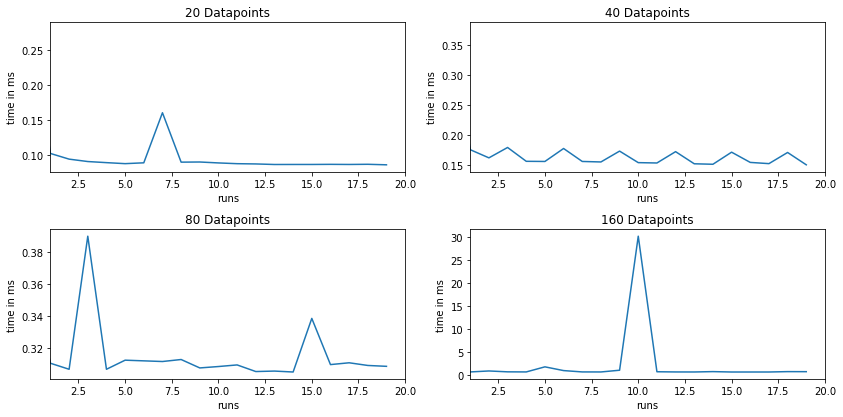

In [14]:
plt.subplot(2, 2, 1)
plt.plot(xml_timer.measurements[0])
plt.title('20 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 2)
plt.plot(xml_timer.measurements[1])
plt.title('40 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 3)
plt.plot(xml_timer.measurements[2])
plt.title('80 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.subplot(2, 2, 4)
plt.plot(xml_timer.measurements[3])
plt.title('160 Datapoints')
plt.xlim(1, RUNS)
plt.xlabel('runs')
plt.ylabel('time in ms')

plt.rcParams['figure.figsize'] = [30 / 2.54, 15 / 2.54]
plt.tight_layout()
plt.show()

### XML - Ergebnisse

In [15]:
df = pd.DataFrame(xml_timer.measurements)
df.columns = ['20 Datapoints', '40 Datapoints', '80 Datapoints', '160 Datapoints']
df

,20 Datapoints,40 Datapoints,80 Datapoints,160 Datapoints
0,0.280833,0.377209,0.363083,0.829416
1,0.101667,0.176167,0.310709,0.621500
2,0.093500,0.162583,0.306958,0.832583
3,0.090042,0.179875,0.389917,0.642083
4,0.088458,0.156833,0.306958,0.619584
5,0.087000,0.156584,0.312625,1.732209
6,0.088208,0.178166,0.312209,0.914792
7,0.160292,0.156584,0.311792,0.621875
8,0.089166,0.155750,0.313041,0.614250
9,0.089375,0.173833,0.307792,0.994416


## Vergleich der Ausführungszeiten

Folgend sollen die Ausführungszeiten der verschiedenen Parsingmethoden in Relation zu den Größen der Konfigurationsdateien betrachtet werden. Die Ergebnisse der Methoden werden dabei grafisch in Form von Balkendiagrammen dargestellt und können somit verglichen werden.

Dabei ist zunächst festzustellen, dass die Ergebnisse über alle Messwertsets den relativen Abstand zueinander einhalten. Es kann darüber hinaus beaobachtet werden, dass dabei XML immer die schnellste Ausführungszeit aufwies, gefolgt von der manuell implementierten Parsingmethode. Der Abstand bewegt sich dabei in einem sehr kleinen Bereich, meist konnte ein Unterschied im einstelligen Millisekundenbereich beobachtet werden. Deutlich mehr Ausführungszeit benötigen dabei jeweils die Methoden unter Verwendung der *pyparsing* Bibliothek bzw. die der Verarbeitung von Konfigurationen im YAML Format. Hier kann in einigen Fällen ein Regredienz um den Faktor 30 bis 100 verzeichnet werden.

Die Ausführungszeiten im Zeitverlauf der einzelnen Messungen ist dabei allerdings unauffälig geblieben. Es sind einzelne Ausläufer festzustellen, welche allerdings nicht zweifelsfrei einzuordnen sind. Durch die generell niedrige Ausführungszeit können Ausschläge durch die Supendierung des Prozesses durch die Scheduling-Mechanismen des Betriebssystems nicht ausgeschlosssen werden. Für die Ermittlung bzw. Evaluierung der gemittelten Ausführungszeiten wurden diese extremen Werte jedoch entfernt, um die Messergebnisse möglichst unverfälscht zu präsentieren.

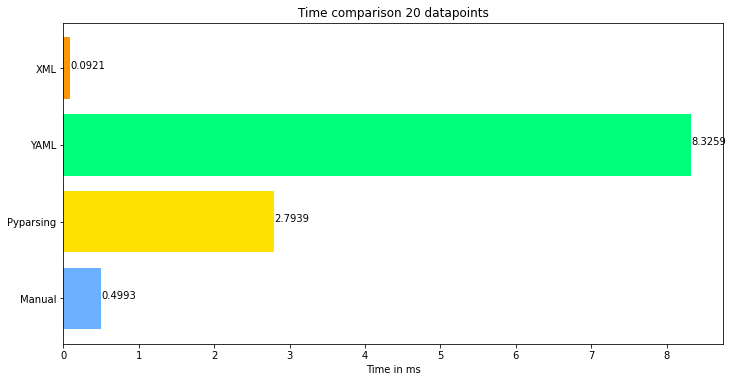

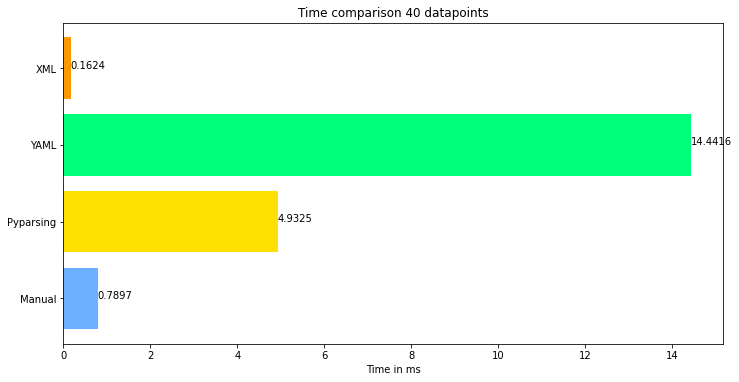

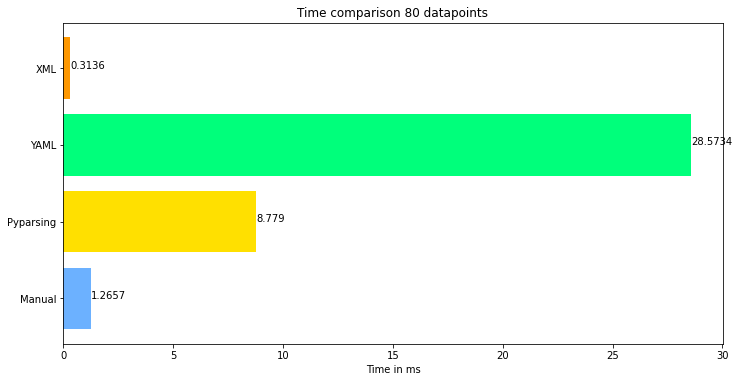

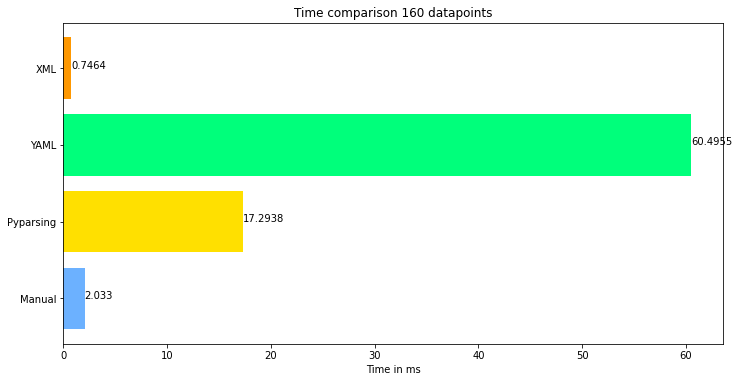

In [16]:
manual_avg = manual_timer.average_time()
pyparsing_avg = pyparsing_timer.average_time()
yaml_avg = yaml_timer.average_time()
xml_avg = xml_timer.average_time()

# Define y-axis labels
labels = ['Manual', 'Pyparsing', 'YAML', 'XML']

# Define y values
y = np.arange(len(labels))

# Define label helper function
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        label_y = bar.get_y() + bar.get_height() / 2
        plt.text(width, label_y, s=f'{round(width, 4)}')

# Define plot helper function
def show_bar_plot(values, title):
    # Create bar plot
    bars = plt.barh(y, values, color=['#6CB1FF', '#FFE000', '#00FF7B', '#FF9800'])

    # Axis labels and styling
    plt.yticks(y, labels)
    plt.xlabel('Time in ms')
    add_labels(bars)

    plt.title(title)
    plt.show()

# Show Plots

## 20 Datapoints
x = [manual_avg[0], pyparsing_avg[0], yaml_avg[0], xml_avg[0]]
show_bar_plot(x, 'Time comparison 20 datapoints')

## 40 Datapoints
x = [manual_avg[1], pyparsing_avg[1], yaml_avg[1], xml_avg[1]]
show_bar_plot(x, 'Time comparison 40 datapoints')

## 80 Datapoints
x = [manual_avg[2], pyparsing_avg[2], yaml_avg[2], xml_avg[2]]
show_bar_plot(x, 'Time comparison 80 datapoints')

## 160 Datapoints
x = [manual_avg[3], pyparsing_avg[3], yaml_avg[3], xml_avg[3]]
show_bar_plot(x, 'Time comparison 160 datapoints')

## Vergleich der Eingabestruktur

Die Struktur der Eingabedateien soll folgend auf die Leserlichkeit durch den Menschen beurteilt werden. Dazu wird jeweils ein Datenpunkt aus den jeweiligen Konfigurationsdateien ausgewählt und den anderen gegenübergestellt. Geachtet wird dabei darauf, dass der Datenpunkt dabei die identische Libg3n Komponente repräsentiert.

Als Beispiel wurde dabei eine Klasse *Train* deklariert, welche zwei Klassenvariablen erhalten soll. Dabei soll die Variable *mass* einen Ganzzahltypen und die Variable *model* einen Zeichenfolge abbilden.

Folgend ist diese Klasse jeweils in Notation der DSL, YAML und XML beschrieben worden:

_Libg3n DSL_

```
class Train
    property mass : int
    property model : str
```
---
_YAML_
```yaml
- class:
    name: Train
    properties:
      - property:
          name: mass
          type: int
      - property:
          name: type
          type: str
```
---
_XML_
```xml
    <class>
        <name>Train</name>
        <property>
            <name>mass</name>
            <type>int</type>
        </property>
        <property>
            <name>model</name>
            <type>str</type>
        </property>
    </class>
```

Bei einem Vergleich kann dabei beobachtet werden, dass bei der Beschreibung per DSL eine deutlich geringere Anzahl von Zeichen benötigt wird. Die Konfigurationsdateien sind dabei, vor allem bei vielen Datenpunkten pro Datei, deutlich kleiner. Darüber hinaus is auffällig, dass die DSL-Notation einen deutlich höhere Lesbarkeit bietet. Dies ist vor allem mit der geringen Anzahl von Symbolen zu begründen, welche sowohl bei YAML als auch bei XML erforderlich sind. XML ist durch die Dopplung von Knotenbezeichnungen, welche jeweils ein öffnendes und ein schließendes Element benötigen, nochmals ungeeigneter für eine leserliche Darstellung der Elemente.

## Fazit

Abschließend lässt sich feststellen, dass für den begrenzten Einsatzbereich der Libg3n Bibliothek, die Defintion einer eigenen DSL und der manuellen Implementation eines Parsers die beste Methodik darstellt.

Die Sprachsturktur von XML bzw. YAML eignen sich außerordentlich, ein besonders breites Spektrum von Notationen abzudecken. Allerdings benötigen sie daher auch eine Vielzahl von Symbolen und Strukturregeln, damit sie eindeutig verarbeitet werden können. Im Gegensatz dazu kommt die Libg3n DSL, durch die starke Eingrenzung des Geltungsbereiches, ohne diese Strukturen aus. Daraus folgt ein deutlich intuitiver und weit gefasster Syntax, welcher zu einer erheblichen Verbesserung der Leserlichkeit von Konfigurationsdateien führt.

Darüber hinaus hat sich das manuelle Parsing, mit Ausnahme von XML, gegen die Mitbewerber im Sinne der Ausführungszeit durchsetzen können. Es kann angenommen werden, dass dies auf die native Implementation bzw. die effiziente Integration der `xml` Bibliothek von Python zurückzuführen ist. Allerdings muss an dieser Stelle angemerkt werden, dass sich hier Unterschiede über alle Eingebegrößen hinweg in einem einstelligen Millisekundenbereich bewegten. Der mögliche Zeitgewinn durch den Einsatz von XML kann dabei durchaus als vernachlässigbar angesehen werden. Zudem überwiegt für den konkreten Anwendungszweck die Leserlichkeit der DSL, da Nutzer von Libg3n somit bemächtigt werden, Konfigurationen intuitiv und zeiteffektiv in Textform definieren zu können.

Eine Evaluation der Stabilität der Ausführungszeiten konnte nicht in zufriedenstellenden Maße durchgeführt werden. Es konnten Spitzen in der Ausführungszeit festgestellt werden, welche allerdings nicht zweifelsfrei einer Ausführung der jeweiligen Parsingmethoden zugeordnet werden können. Zudem sind diese Spitzen nur in Bezug zu den mittleren Ausführungszeiten bemerkbar, da sich die Ausführungszeiten über alle Messets hinweg ebenfalls nur in einem niedrigen Millisekundenbreich unterschieden. Bei weiterer Evaluierung der Methoden kann durch eine höhere Anzahl von Datenpunkten ein expliziteres Ergebnis erlangt werden.

## Quellen

[1] https://tomassetti.me/guide-parsing-algorithms-terminology/

[2] https://github.com/matplotlib/matplotlib

[3] https://github.com/pandas-dev/pandas

[4] https://github.com/numpy/numpy

[5] https://www.wordnik.com/words/lexical%20analysis

[6] https://github.com/pyparsing/pyparsing

[7] https://yaml.org

[8] https://www.home.uni-osnabrueck.de/elsner/Skripte/xml.pdf